# Ordered phases in rydberg systems

In this example notebook, we show how one can prepare ordered phases in Rydberg systems, focusing on the 1D $Z_2$ phase and the 2D checkerboard phase. We will use an adiabatic transition to prepare these many-body ground states.

## Adiabatic evolution

The adiabatic theorem of quantum mechanics states that 

>A physical system remains in its *instantaneous* eigenstate if a given perturbation is acting on it slowly enough and if there is a gap between the eigenvalue and the rest of the Hamiltonian's spectrum. (Born & Fock, 1928)

In other words, a slow-enough change in the parameters of the Hamiltonian will not induce transitions between its ground state and excited states: If the system starts in the ground state of the Hamiltonian at the beginning, it will smoothly transition into the ground state of the Hamiltonian at the end.

The adiabatic theorem plays a key role in preparing the desired many-body ground states in the Rydberg system, the Hamiltonian of which can be expressed as

\begin{align}
H(t) = \sum_{k=1}^N \frac{\Omega(t)}{2}\left(|g_k\rangle\langle r_k| + |r_k\rangle\langle g_k|\right) - \Delta_\text{global}(t){n}_k + \sum_{j<k}V_{jk}{n}_j{n}_k,
\end{align}

where, for simplicity, we set the phase and the shifting field (See notebook 00 for detailed description of this Hamiltonian) to be zero throughout this notebook. We schedule the the driving amplitude $\Omega(t)$ to start from zero ($\Omega(t=0)=0$). Hence, with negative detuning ($\Delta_\text{global}(t=0)<0$), the initial state where all atoms are in the ground state ($\langle n_k\rangle =0$) is the lowest energy eigenstate of the Hamiltonian, the many-body ground state.

To arrive at a target Hamiltonian where the excited states of the atoms are favored, we ramp up the detuning $\Delta_\text{global}$ from large negative to large positive. During the ramp, we apply a large driving amplitude $\Omega$ to open an energy gap between the first excitied state and the ground state. According to the adiabatic theorem, if the ramping is slow enough, the system remains in the many-body ground state throughout the evolution. At the end of the AHS program, the Rabi frequency will be turn off and since $\Delta_\text{global}>0$, all the atoms tend to stay in the Rydberg state to lower the energy of the system. However, due to the strong Rydberg interaction, only one atom can be excited to the Rydberg state within its blockade radius.

For a 1D chain of atoms, if we adjust the separation between the atoms such that only neighboring atoms are within the blockade radius, then we will arrive at a state where every second atom is excited, this is called the "$Z_2$ phase". For a 2D square array of atoms, a similar "checkerboard phase" emerges. The common feature of these phases is that the atoms are excited to the Rydberg states in an alternative pattern, complying to the blockade constraint, as shown in the figure below (black and white sites represent Rydberg and ground state atoms respectively).

![Blockade_examples.png](Blockade_examples.png)

We will realize these phases in this notebook. To begin, we import the necessary packages.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from braket.ahs.atom_arrangement import AtomArrangement

from braket.ahs.analog_hamiltonian_simulation import AnalogHamiltonianSimulation

from utils import show_register, show_global_drive, show_final_avg_density, get_drive

from braket.devices import LocalSimulator

## 1D $Z_2$ phase 

Here we consider a 1D chain of 9 atoms with neighboring atoms separated by $5.5\mu m$. The setup of the system can be generated as follows

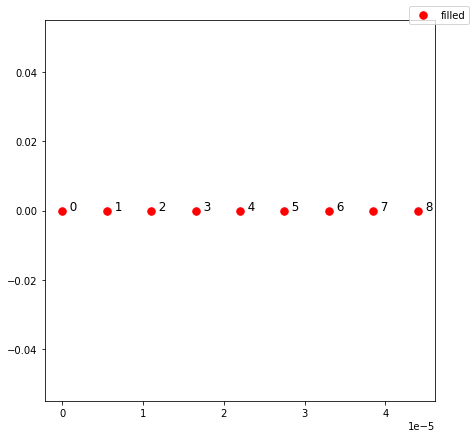

In [2]:
register = AtomArrangement()
separation = 5.5e-6  # in meters 
num_atoms = 9

for k in range(num_atoms):
    register.add([k * separation, 0])
    
show_register(register)

In order to prepare the $Z_2$ ordered state for the atomic chain, we shall design an AHS program that drives the system adiabatically. As described above, we start from $\Omega(t=0)=0$ with $\Delta(t=0)<0$, followed by turning on $\Omega(t)$ and ramping up $\Delta(t)$. We will turn off the driving amplitude at the end of the program. This program can be specified as follows.

In [3]:
amplitude_min = 0
amplitude_max = 6.3e6  # rad / s
detuning_min = -6e6  # rad / s
detuning_max = 15e6  # rad / s

time_max = 4e-6  # s
time_ramp = 5e-7  # s

time_points = [0, time_ramp, time_max - time_ramp, time_max]
amplitude_values = [amplitude_min, amplitude_max, amplitude_max, amplitude_min]
detuning_values = [detuning_min, detuning_min, detuning_max, detuning_max]
phase_values = [0, 0, 0, 0]


drive = get_drive(time_points, amplitude_values, detuning_values, phase_values)

We can plot the waveforms of these driving fields to make sure that they are correctly specified.

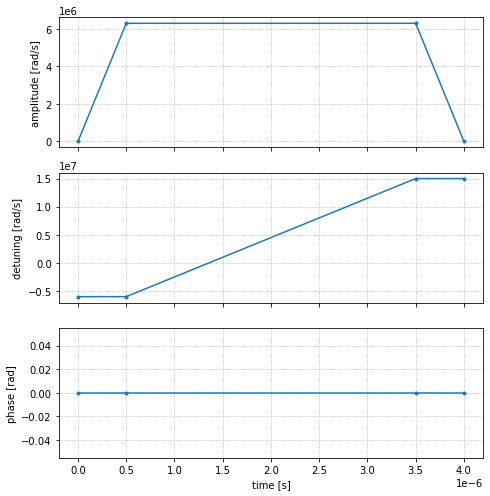

In [4]:
show_global_drive(drive)

Finally, we construct out AHS program from the atomic registers, and the Hamiltonian defined above. 

In [5]:
ahs_program = AnalogHamiltonianSimulation(
    register=register, 
    hamiltonian=drive
)

Before runnig the program on Quera's Aquila device (See notebook 01), we can first run it on the local simulator to make sure the outcome is the expected $Z_2$ state. 

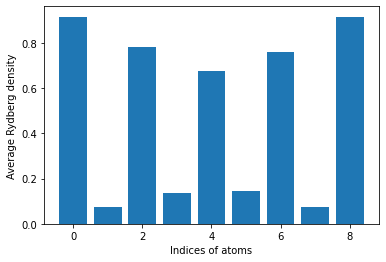

In [6]:
device = LocalSimulator("braket_ahs")
result = device.run(ahs_program, shots=1000).result()
show_final_avg_density(result)

We see that the average Rydberg density approximately forms the $Z_2$ pattern. The discrepancy can be attributed to finite size of the system and nonadiabaticity throughout the evolution. We expect that as one increase the system size and the duration of the AHS program, the final Rydberg density will approach the ideal $Z_2$ pattern.

The $Z_2$ phase can be characterized by the pairwise density covariance $g_{ij}$ of the $i$-th and the $j$-th atom, which is defined as

\begin{align}
g_{ij} = \langle n_i n_j\rangle - \langle n_i\rangle\langle n_j\rangle,
\end{align}

where $\langle\cdot\rangle$ is the average over the shots.

In [30]:
def get_pairwise_g(result):
    post_sequences = np.array([list(measurement.post_sequence) for measurement in result.measurements])
    return np.cov(post_sequences.T)

gij = get_pairwise_g(result)

The Rydberg density covariance function can be visualized as follows.

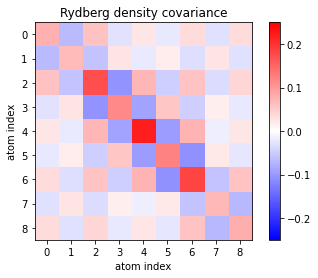

In [33]:
plt.imshow(gij, cmap='bwr', vmin=-0.25, vmax=+0.25)
plt.xticks(range(num_atoms), [f'{i}' for i in range(num_atoms)])
plt.xlabel("atom index")
plt.yticks(range(num_atoms), [f'{j}' for j in range(num_atoms)])
plt.ylabel("atom index")
plt.title('Rydberg density covariance')
plt.gca().set_aspect('equal')
plt.colorbar()
plt.show()

For more explanation and interpretation of the Rydberg density covariance functions, see "Probing many-body dynamics on a 51-atom quantum simulator" by [Bernien et al.](https://arxiv.org/abs/1707.04344). 

## 2D checkerboard phase 

In two dimension, Rydberg system can exhibit the checkerboard phase, which is analogues to the $Z_2$ phase in 1D. For simplicity, here we create a $3\times 3$ square lattice.

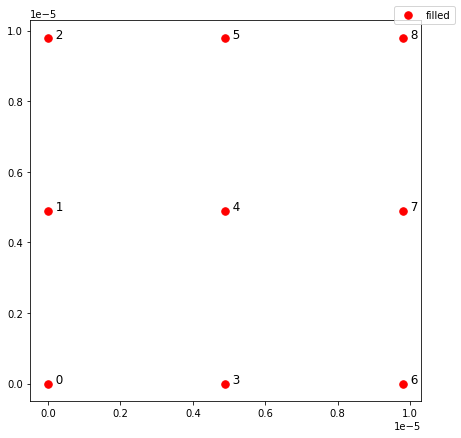

In [34]:
register_2D = AtomArrangement()
separation = 4.9e-6  # in meters 

for k in range(3):
    for l in range(3):
        register_2D.add((k * separation, l * separation))

show_register(register_2D)

The driving field is similar to the one for generating the $Z_2$ phase, with slight modifications for the parameters. 

In [35]:
amplitude_min = 0       
amplitude_max = 6.3e6 # good

detuning_min = -3e6
detuning_max = 10e6

time_max = 4e-6
time_ramp = 10e-7

time_points = [0, time_ramp, time_max - time_ramp, time_max]
amplitude_values = [amplitude_min, amplitude_max, amplitude_max, amplitude_min]
detuning_values = [detuning_min, detuning_min, detuning_max, detuning_max]
phase_values = [0, 0, 0, 0]


drive = get_drive(time_points, amplitude_values, detuning_values, phase_values)

Finally we assemble the 2D array with the driving field, and run the AHS program on the local simulator.

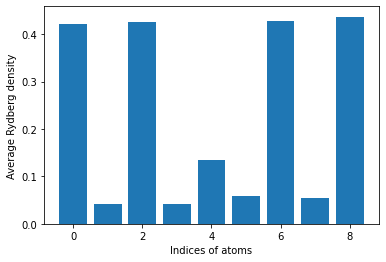

In [36]:
ahs_program_2D = AnalogHamiltonianSimulation(
    register=register_2D, 
    hamiltonian=drive
)

result_2D = device.run(ahs_program_2D, shots=1000, steps=200).result()
show_final_avg_density(result_2D)

We see that the overal pattern mimics the checkerboard pattern, but the central site suffers strong discrepancy. This is due to the finite size of the system and the finite duration of the AHS program, which cause non-adiabatic errors.

## Realizing $Z_2$ and checkerboard phase on a QPU